In [33]:
snr=10e3
samples=1000
mod_size=2
quant_size=0.001
hist_bins_max = 600

plot=True
debug=False

In [34]:
import pandas as pd
import numpy as np
# pd.set_option("display.max_rows",1000)
pd.set_option("display.max_columns",1000)
pd.set_option('expand_frame_repr',False)
pd.set_option('display.max_colwidth',1000)
import plotly as py
import cufflinks
py.offline.init_notebook_mode(connected=True)
import pylab as plt

In [35]:
# print(__file__)
import os, sys
root_path=os.path.abspath('').replace('\\','/').rsplit('int_force',1)[0]
sys.path.append(root_path)
import int_force
plt.rc('figure', facecolor='w')
fig_size_inch=11
plt.rc('figure', figsize=(fig_size_inch,fig_size_inch))

In [36]:
# random cov and generate data
if 0:
    cov=int_force.rand_data.rand_data.rand_cov(snr=snr)
    print(cov)
else:
    cov=np.mat([[ 0.67828027, -0.14103396], [-0.14103396,  0.02942934]])
    
cov_angle=int_force.rand_data.find_slop.get_cov_ev(cov)[1]
data = int_force.rand_data.rand_data.random_data(cov, samples)

# modulo and quantization
tmp = int_force.methods.methods.sign_mod(data, mod_size)
tmp = int_force.methods.methods.to_codebook(tmp, quant_size, 0)
tmp = int_force.methods.methods.from_codebook(tmp, quant_size, 0)

tmp.columns = [['after'] * 2, tmp.columns.values]
data.columns = [['before'] * 2, data.columns.values]
data = data.join(tmp)
del tmp

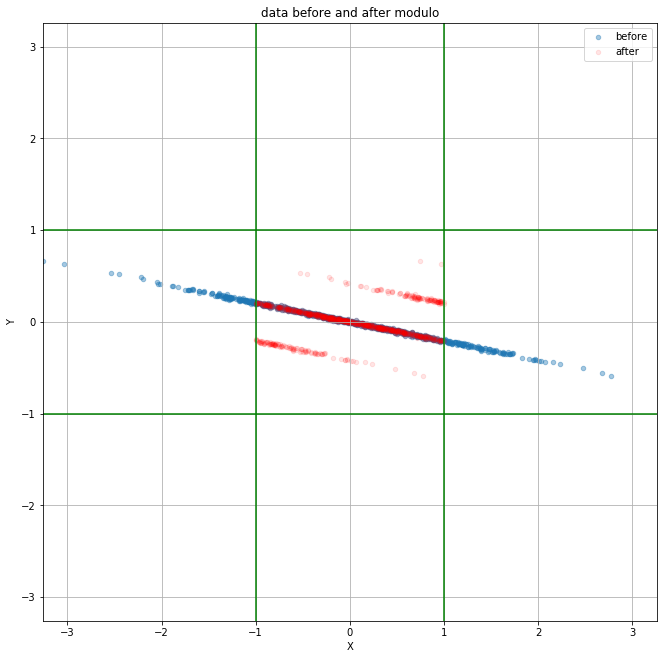

In [37]:
if 1:
    max_num=data[['after','before']].abs().values.max()
    ax=data.before.plot.scatter(x='X', y='Y', label='before', alpha=0.4, title='data before and after modulo')
    data.after.plot.scatter(x='X', y='Y', label='after', 
                            ax=ax, c='red', alpha=0.1, grid=True, xlim=[-max_num,max_num],ylim=[-max_num,max_num])
    for l in [-mod_size/2, mod_size/2]:
        plt.axvline(l, color='g') 
        plt.axhline(l, color='g')     
else:
    before_after=data[['after','before']].stack(0).reset_index(1,drop=False).rename(columns=dict(level_1='state'))
    fig=before_after.figure(
        kind='scatter', x='X', y='Y', categories='state', size=4, opacity=0.6)
    py.offline.iplot(fig)

closing picture


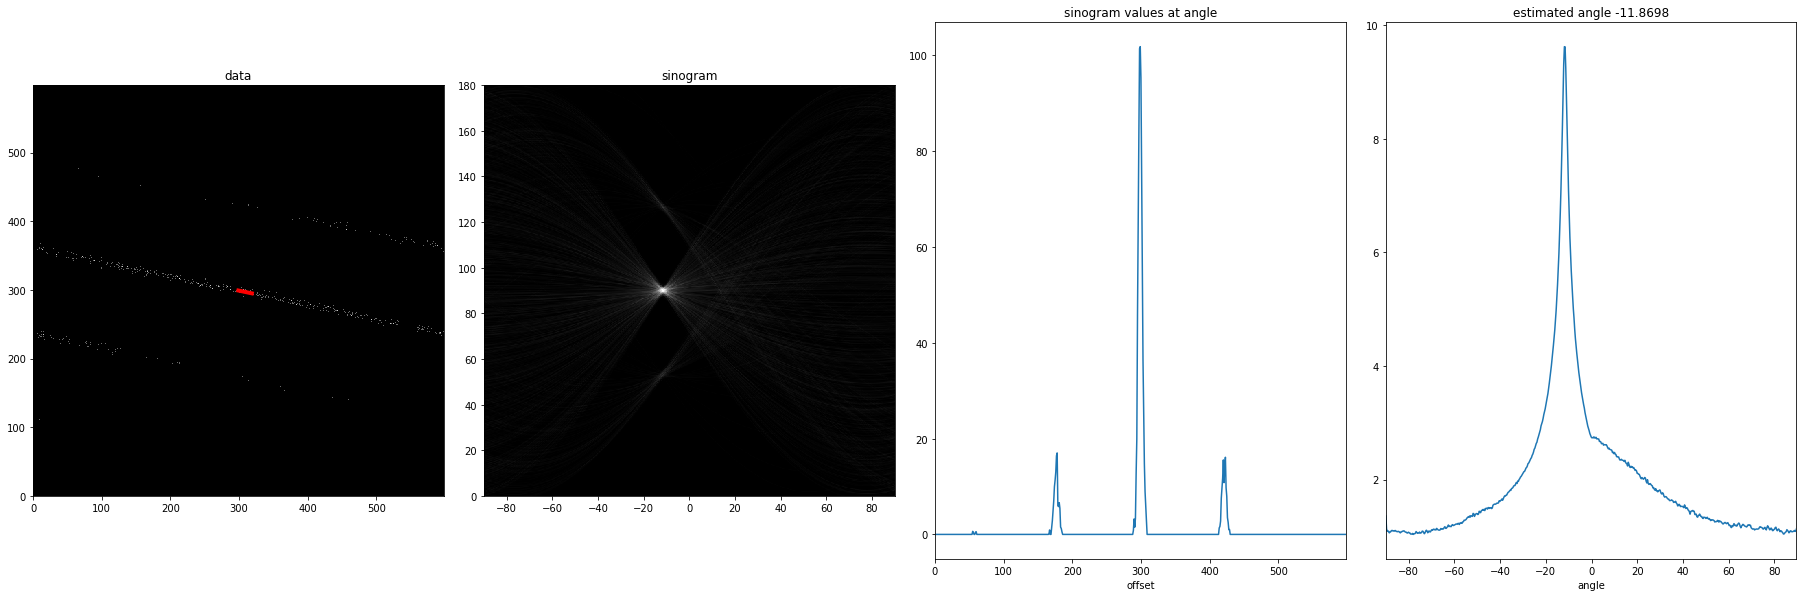

In [38]:
# doing sinogram
sinogram_dict = int_force.methods.sinogram.calc_sinogram(data.after.X.values, data.after.Y.values, hist_bins_max=hist_bins_max, plot=plot, quant_size=quant_size)

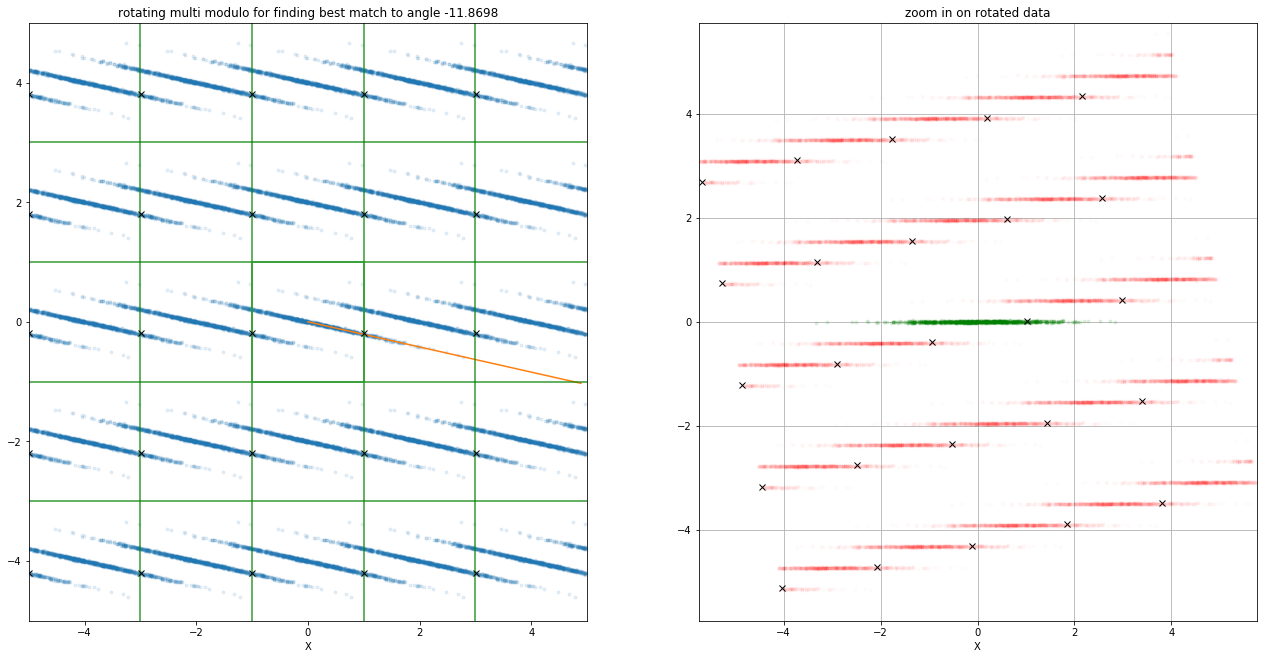

In [39]:
# rotating by sinogram angle
tmp = int_force.methods.sinogram.find_closest(number_of_shift_per_direction=2, data_after=data.after, mod_size=mod_size, angle_by_std=sinogram_dict['angle_by_std'],plot=plot)

In [40]:
data = pd.merge(tmp, data, left_on=[('remove', 'x_at_mod'), ('remove', 'y_at_mod')], right_on=[('after', 'X'), ('after', 'Y')], how='right').T.sort_index().T.drop('remove', axis=1)
del tmp
error=data.recovered - data.before
error.columns = [['error']*2, error.columns.values]
data = data.join(error)
del error
mse = data.error.pow(2).values.mean()
rmse=mse ** 0.5
print('rmse: %f'%rmse)
data.head()

rmse: 0.000289


after           before           distances_angle major_distance minor_distance modulo_center_x modulo_center_y recovered             stat x_after_rotation y_after_rotation     error          
       X      Y         X         Y distances_angle major_distance minor_distance modulo_center_x modulo_center_y         X      Y  distance x_after_rotation y_after_rotation         X         Y
0 -0.998 -0.194  1.001959 -0.193608        0.912164       0.016248       1.020478             2.0             0.0     1.002 -0.194  0.036657         1.020478         0.016248  0.000041 -0.000392
1 -0.998  0.195 -0.998183  0.194755        0.814006       0.014446       1.016770             0.0             0.0    -0.998  0.195  0.034782        -1.016770        -0.014446  0.000183  0.000245
2 -0.997  0.196 -0.996877  0.195688        0.747850       0.013262       1.015997             0.0             0.0    -0.997  0.196  0.033582        -1.015997        -0.013262 -0.000123  0.000312
3 -0.996 -0.200  1.004343 -0.200307        0.603755       0.010787       1.023670             2.0             0.0     1.004 -0.200  0.031261         1.023670         0.010787 -0.000343  0.000307
4 -0.992 -0.190  1.008418 -0.189941        1.195227       0.021396       1.025527             2.0             0.0     1.008 -0.190  0.041907         1.025527         0.021396 -0.000418 -0.000059